# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 2: Introduction to Non-linear Square and Machine Learning*

## Preliminary: Certificate of Work (5 marks)


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Tasnia | Ibnat | Tasnia Ibnat | 4 | 25 |
| Member 2: | Yingxue | Zhang | Yingxue Zhang | 5 | 25 |
| Member 3: | Urnisha Saha | Prapti | Urnisha Saha Prapti  | 3 | 25 |
| Member 4: | Jingfeng | Sun | Jingfeng Sun | 4 | 25 |


# **PART 1: Non-linear Estimation - LSE & Gradiant Decent (35 Marks)**

The following materials will be our states of interest, and we are going to estimate them using **Least Square method** and **Gradient Descent method**

## **SinglePointPositioning Formulas**

### **Observations:** Pseudorange [m]

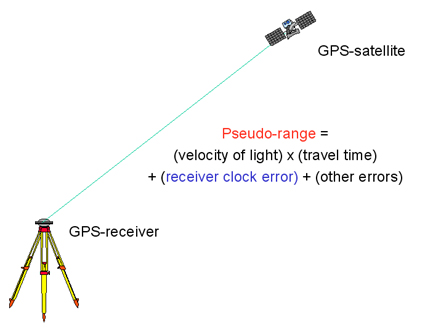

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.


## **Setup & Intialization for LSE and Gradient Decent (5 Marks)**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares

In [27]:
# Load the psuedorange measurements and satellites' positions files, store them in the format of numpy array
# Add small random perturbations in the range (0, 0.5) to pseudorange measurements to simulate measurement noise
# (hint: use pandas library to parse excel files into dataframe first, then convert them to numpy arrays)
# (1 marks)

df_pseudorange = pd.read_excel("pseudoranges.xlsx")
df_sat_pos     = pd.read_excel("satellite_position.xlsx")
np.random.seed(42)  # For reproducible results
pseudorange = df_pseudorange["P"].to_numpy().astype(float)
sat_pos     = df_sat_pos[["x", "y", "z"]].to_numpy().astype(float)
np.random.seed(42)
pseudorange = pseudorange + np.random.uniform(0, 0.5, size=pseudorange.shape)

In [3]:
# define the number of measurements n and the number of unknown states m
# (2 mark)
n = pseudorange.shape[0]
m = 4

In [4]:
# GroundTruth coordiantes of the receiver
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

In [5]:
# define a function called euclidean_norm, which computes the geometric distances between satellites and receiver
# the input of the function should be two arrays: receiver_pos and satellite_pos
# the function should return an array of distance between satellites and receiver
# you can either use the numpy function or code the math manually
# (2 marks)
def euclidean_norm(receiver_pos, satellite_pos):
    receiver_pos = np.asarray(receiver_pos).reshape(3,)  # [x_r, y_r, z_r]
    diff = satellite_pos - receiver_pos                  # shape (n, 3)
    distance = np.sqrt(np.sum(diff**2, axis=1))          # Euclidean norm per satellite
    return distance


## **Non-linear LSE (15 Marks)**

### Step 1: Given that the variance of observation is 1.2 (m^2), define the weight matrix P (0.5 marks)

In [18]:
P = (1.0 / 1.2) * np.eye(n)

### Step 2: set the initial states as [100.0, -50.0, 25.0, 1000.0] (0.5 mark)

In [19]:
x_0 = np.array([100.0, -50.0, 25.0, 1000.0], dtype=float)

### Step 3: initialize the corrections array as 10s, iteration loop counter i as zero and related arrays (1 mark)

In [20]:
delta = np.ones(m) * 10.0
i = 0

# given empty arrays to store results (no need to fill anything here)
arr_w = []
arr_delta=[]
arr_err_pos = []
arr_i = []
x_hat = x_0.copy()

### Step 4: define a function named design_matrix which computes the design matrix A of this LSE problem (3 mark)

the input of this funciton should be: estimated unknown states array, satellites positions array and geometric distance array

the function should return an two-dimensional array which represents the design matrix A

#### Calculation Formula for the Design Matrix \( A \)

Let the position vectors of the satellite and receiver be:

- **r** = (r_x, r_y, r_z) for the receiver
- **s** = (s_x, s_y, s_z) for the satellite

The Euclidean distance between the satellite and receiver is given by:

$$
\rho = \sqrt{(s_x - r_x)^2 + (s_y - r_y)^2 + (s_z - r_z)^2}
$$

#### Partial Derivatives of the Distance with Respect to \(x\), \(y\), and \(z\):

To construct the design matrix, we compute the partial derivatives of the distance function with respect to the receiver's \(x\), \(y\), and \(z\) coordinates. Here's the detailed process for one of them, and the others follow the same procedure.

##### Partial derivative with respect to \(r_x\):

Taking the derivative with respect to \(r_x\), we use the chain rule:

$$
\frac{\partial \rho}{\partial r_x} = \frac{\partial}{\partial r_x} \left( \sqrt{(s_x - r_x)^2 + (s_y - r_y)^2 + (s_z - r_z)^2} \right)
$$

First, apply the derivative of the square root:

$$
\frac{\partial \rho}{\partial r_x} = \frac{1}{2 \sqrt{(s_x - r_x)^2 + (s_y - r_y)^2 + (s_z - r_z)^2}} \cdot 2 (r_x - s_x)
$$

Simplifying:

$$
\frac{\partial \rho}{\partial r_x} = \frac{r_x - s_x}{\rho}
$$

##### Partial derivatives for \(r_y\) and \(r_z\):

The partial derivatives with respect to \(r_y\) and \(r_z\) follow the same procedure:

$$
\frac{\partial \rho}{\partial r_y} = \frac{r_y - s_y}{\rho}
$$

$$
\frac{\partial \rho}{\partial r_z} = \frac{r_z - s_z}{\rho}
$$

#### The Design Matrix \(A\):

Thus, the design matrix \(A\) can be expressed as:

$$
A = \left[
\begin{array}{ccc|c}
\frac{s_x - r_x}{\text{distance}} & \frac{s_y - r_y}{\text{distance}} & \frac{s_z - r_z}{\text{distance}} & -1
\end{array}
\right]
$$

Where:
- The first three columns represent the partial derivatives of the distance with respect to x, y, and z coordinates
- The last column of -1 corresponds to the constant term in the least squares equation

This matrix is used for least squares estimation in positioning or navigation applications.


In [21]:
def design_matrix(receiver_pos, satellite_pos, distance):
    receiver_pos = np.asarray(receiver_pos).reshape(4,)
    rx, ry, rz = receiver_pos[:3]
    sx = satellite_pos[:, 0]
    sy = satellite_pos[:, 1]
    sz = satellite_pos[:, 2]
    ax = (rx - sx) / distance
    ay = (ry - sy) / distance
    az = (rz - sz) / distance
    A = np.column_stack([ax, ay, az, -np.ones_like(ax)])
    return A

### Step 5: start the iteration for the LSE (4 mark)

define the convergence criteria for the 'while' loop

the convergence criteria is that the corrections delta are less than 0.008 (i.e., <0.1 m), for receiver's position x,y,z part

In [22]:
while  np.any(np.abs(delta[:3]) >= 0.008):
        # compute the geometric distance between Satellites and receiver, using the euclidean_norm function we just defined
       # (0.5 marks)
       distance = euclidean_norm(x_hat[:3], sat_pos)

       # compute the design matrix A
       # (0.5 marks)
       A = design_matrix(x_hat, sat_pos, distance)

       # compute the misclosure array w: observed - computed
       # model: P = ρ - cdT
       # (0.5 marks)
       pred_pseudo = distance - x_hat[3]
       w = pseudorange - pred_pseudo

       # compute the corrections delta
       # (0.5 marks)
       N = A.T @ P @ A              # normal matrix
       u = A.T @ P @ w
       delta = np.linalg.solve(N, u)

       # update the estimated states
       x_hat = x_hat + delta

       # store norms for analysis & plotting
       arr_w.append(np.linalg.norm(w))
       arr_delta.append(np.linalg.norm(delta))
       arr_err_pos.append(np.linalg.norm(x_hat[:3] - GroundTruth))
       arr_i.append(i)

       # update iteration index
       i += 1

# After convergence, compute the A Posteriori Variance of Unit Weight
# (0.5 marks)
apv = (w.T @ P @ w) / (n - m)

# compute the Covariance matrix of estimated states
# (0.5 marks)
C_x_hat = np.linalg.inv(N) * apv

### Step 6: Results Printing (1 mark)

Print:

* estimated states,
* corrections array,
* estimated measurements residuals,
* A posteriori Variance of Unit Weight,
* Covariance matrix of estimated states,
* number of iterations,
* 3-D position errors


In [23]:
print("Estimated states x_hat:", x_hat)
print("Final corrections delta:", delta)
print("Final residuals w:", w)
print("A Posteriori Variance of Unit Weight (σ0^2):", apv)
print("Covariance matrix of estimated states C_x_hat:\n", C_x_hat)
print("Number of iterations:", i)
pos_error = np.linalg.norm(x_hat[:3] - GroundTruth)
print("3-D position error [m]:", pos_error)


Estimated states x_hat: [-1.63349246e+06 -3.65162953e+06  4.95248542e+06 -6.70247977e+00]
Final corrections delta: [ 3.24330127e-06  6.43110010e-06 -1.77329652e-05  2.09957835e-05]
Final residuals w: [ 0.20483172  0.34240459 -0.98043974  0.06599824  0.0470863  -1.57080159
 -0.30920948  1.69957656  0.33524236  0.74094027 -0.57575024]
A Posteriori Variance of Unit Weight (σ0^2): 0.901367713041337
Covariance matrix of estimated states C_x_hat:
 [[ 0.3457467   0.07534978 -0.09147658  0.07903424]
 [ 0.07534978  0.46020454 -0.62851089  0.3983237 ]
 [-0.09147658 -0.62851089  2.21260707 -1.19415431]
 [ 0.07903424  0.3983237  -1.19415431  0.75634562]]
Number of iterations: 5
3-D position error [m]: 5.425801843828999


### Step 7: Comment on the computed A Posteriori Variance of Unit Weight value and the Covariance matrix of estimated states (1 mark)

In [24]:
# your answer here
#My a-posteriori variance of unit weight σ₀² is of the same order and slightly smaller than the assumed observation variance 1.2 m².
#Which means the residuals match the noise level we assumed and the LSE model is statistically reasonable (no obvious gross errors).
#The covariance matrix escribes the precision of the estimated states.
#Its diagonal elements are the variances of x, y, z, cdT.
#The off-diagonal terms are covariances showing that some parameters, especially position and clock bias, are correlated.

### Step 8: Using the imported matplotlib, plot the following. Make sure to include proper axes information, legend, grid lines and title. (3 marks)

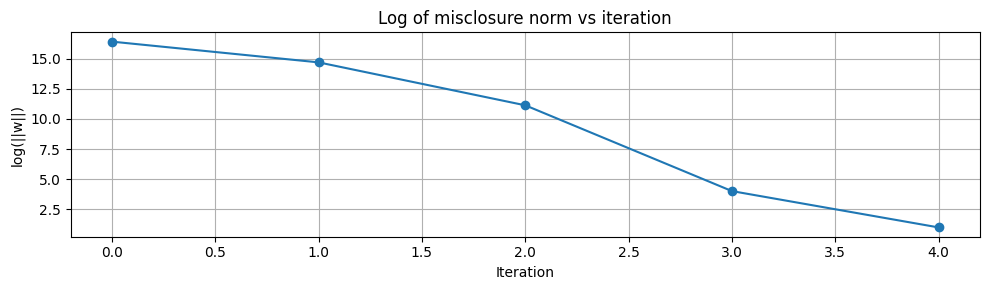

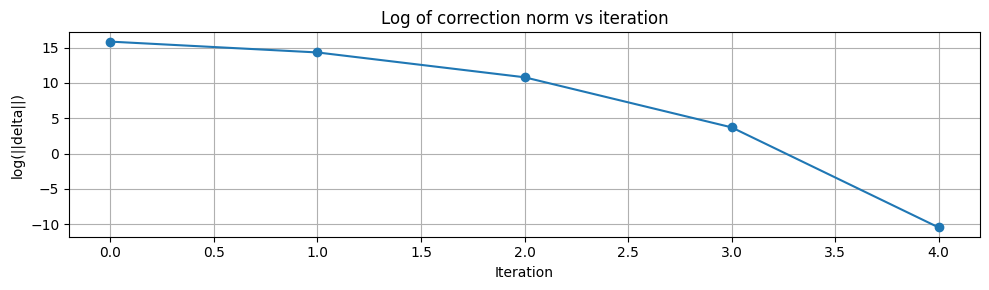

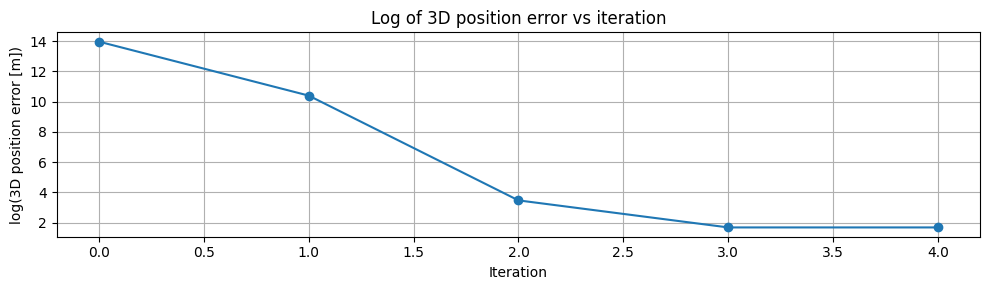

In [25]:
# 1. Plot log of the misclosure w against the LSQ iteration number i
# (1 marks)
arr_i       = np.array(arr_i)
arr_w       = np.array(arr_w)
arr_delta   = np.array(arr_delta)
arr_err_pos = np.array(arr_err_pos)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(arr_i, np.log(arr_w), marker="o")
ax.set_xlabel("Iteration")
ax.set_ylabel("log(||w||)")
ax.set_title("Log of misclosure norm vs iteration")
ax.grid(True)
fig.tight_layout()
plt.show()

# 2. Plot log of the corrections delta against the LSQ iteration number i
# (1 marks)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(arr_i, np.log(arr_delta), marker="o")
ax.set_xlabel("Iteration")
ax.set_ylabel("log(||delta||)")
ax.set_title("Log of correction norm vs iteration")
ax.grid(True)
fig.tight_layout()
plt.show()

# 3. Plot log of the 3D position errors against the LSQ iteration number i
# (1 marks)
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(arr_i, np.log(arr_err_pos), marker="o")
ax.set_xlabel("Iteration")
ax.set_ylabel("log(3D position error [m])")
ax.set_title("Log of 3D position error vs iteration")
ax.grid(True)
fig.tight_layout()
plt.show()

### Step 9: Describe the phenomena or pattern you recognize for each plot, and explain such phenomena (1 marks)

In [29]:
# your answer here
# The residuals, corrections, and position errors drop significantly in the initial iterations
# as the estimator rapidly corrects the coarse initial guess.
# As the solution approaches the true value, the changes become smaller and the curves flatten,
# confirming that the system has converged to a stable solution.

### Bonus: this is just for fun (no marks allocated)

now that you have estimated the receiver's position in Earth-center-earth-fixed (ECEF)

you can use this tool: https://www.oc.nps.edu/oc2902w/coord/llhxyz.htm to convert it to latitude, longitude and height

and find where is it on google earth!

## **Non-linear Gradient Decent (15 Marks)**

### Step 0: Intialize empty arrays (there is no need to fill anything here)

In [30]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

### Step 1: Define the Cost Function (1 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [31]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(rec_pos, cdT, sat_pos, pseudorange):
    rec_pos = np.asarray(rec_pos).reshape(3,)
    distance = euclidean_norm(rec_pos, sat_pos)
    residuals = pseudorange - (distance - cdT)
    L = np.sum(residuals**2)
    return L

### Step 2: Define the Gradient Computation Function (1 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


**Recall elements of the design matrix A in the previous LSE function.**

In [32]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(rec_pos, cdT, sat_pos, pseudorange):
    rec_pos = np.asarray(rec_pos).reshape(3,)
    distance = euclidean_norm(rec_pos, sat_pos)
    residuals = pseudorange - (distance - cdT)
    diff = rec_pos - sat_pos
    distance_safe = np.where(distance == 0, 1e-12, distance)
    factor = residuals / distance_safe
    grad_xyz = -2.0 * np.sum((factor[:, None]) * diff, axis=0)
    grad_cdT = 2.0 * np.sum(residuals)
    grad = np.hstack([grad_xyz, grad_cdT])
    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.08, 10000, 8e-7 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [45]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, sat_pos, learning_rate=0.08,
                     max_iters=10000, tolerance=8e-7):

    global steps_count, arr_cost, arr_grad, arr_err

    # >>> add these 4 lines <<<
    arr_cost = []
    arr_grad = []
    arr_err  = []
    steps_count = 0
    # <<< end of new lines <<<

    # initalize the estimates
    X = np.array([50.0, -25.0, 15.0, 500.0])

    for iteration in range(max_iters):
        rec_pos = X[:3]
        cdT = X[3]

        current_cost = cost_function(rec_pos, cdT, sat_pos, pseudorange)
        grad = gradient(rec_pos, cdT, sat_pos, pseudorange)

        X_new   = X - learning_rate * grad
        new_cost = cost_function(X_new[:3], X_new[3], sat_pos, pseudorange)

        # log
        arr_cost.append(current_cost)
        arr_grad.append(grad.copy())
        arr_err.append(X[:3] - GroundTruth)

        if abs(new_cost - current_cost) < tolerance:
            steps_count = iteration + 1
            X = X_new
            break

        X = X_new

    else:
        steps_count = max_iters

    return X

### Step 4: Parameters Optimization & Results Printing (2 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [46]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# print the mentioned metrics
print("Optimized parameters [x, y, z, cdT]:")
print(optimized_params)
pos_error_vec = optimized_params[:3] - GroundTruth
pos_error_norm = np.linalg.norm(pos_error_vec)
print("Final 3D position error [m]:", pos_error_norm)
print("Number of steps taken (or max_iters):", steps_count)
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
final_grad = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final cost value:", final_cost)
print("Final gradient:", final_grad)

Optimized parameters [x, y, z, cdT]:
[-1616184.59596918 -4389634.8224274   8306848.12640079 -6327556.24467303]
Final 3D position error [m]: 3434636.7194235995
Number of steps taken (or max_iters): 10000
Final cost value: 255692970062035.47
Final gradient: [ 7.33346447e+06  2.01747337e+07 -3.40946836e+07 -1.04702035e+08]


### Step 5: Cost vs Steps Plot & Analysis (1 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

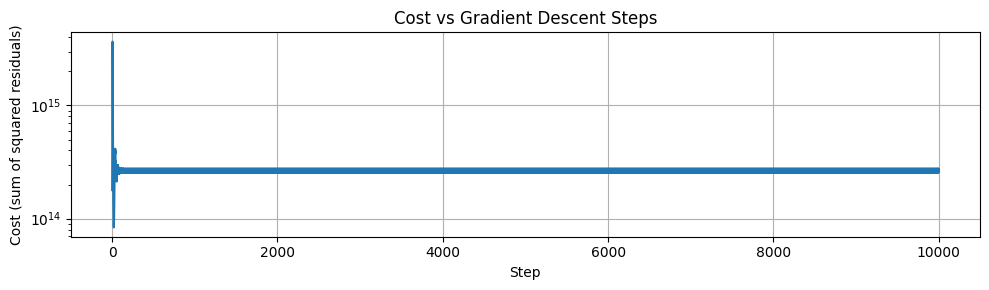

In [47]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# (0.5 marks)
steps = np.arange(len(arr_cost))
ax.semilogy(steps, arr_cost)
ax.set_xlabel("Step")
ax.set_ylabel("Cost (sum of squared residuals)")
ax.set_title("Cost vs Gradient Descent Steps")
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern (0.5 marks)
# The plot indicates that the algorithm failed to converge.
# The cost value remains extremely high and exhibits rapid oscillations instead of decreasing.
# This phenomenon occurs because the learning rate (0.08) is too large for this problem
# causing the gradient descent to overshoot the minimum repeatedly.

### Step 6: Gradients vs Steps & Analysis(1 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

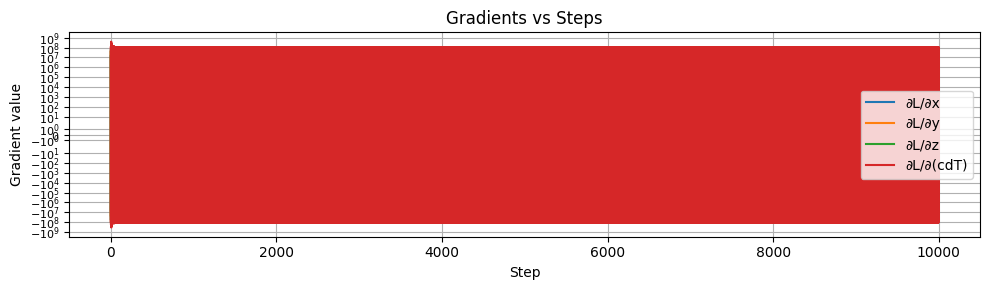

In [50]:
fig , ax = plt.subplots(nrows=1,ncols=1, figsize=(10,3))
# (0.5 marks)
grad_array = np.array(arr_grad)
steps = np.arange(grad_array.shape[0])
ax.plot(steps, grad_array[:,0], label="∂L/∂x")
ax.plot(steps, grad_array[:,1], label="∂L/∂y")
ax.plot(steps, grad_array[:,2], label="∂L/∂z")
ax.plot(steps, grad_array[:,3], label="∂L/∂(cdT)")
ax.set_yscale("symlog")
ax.set_xlabel("Step")
ax.set_ylabel("Gradient value")
ax.set_title("Gradients vs Steps")
ax.legend()
ax.tick_params(axis='y', labelsize=8)
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern (0.5 marks)
# The plot shows that the gradients are not converging to zero as expected.
# Instead, they are oscillating between large positive and negative values (order of 10^8).
# This pattern indicates that the learning rate (0.08) is too large for this specific cost function.
# The optimization step is too big, causing the algorithm to constantly overshoot the minimum,
# bouncing back and forth.

### Step 7: Positioning errors vs Steps & Analysis(1 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

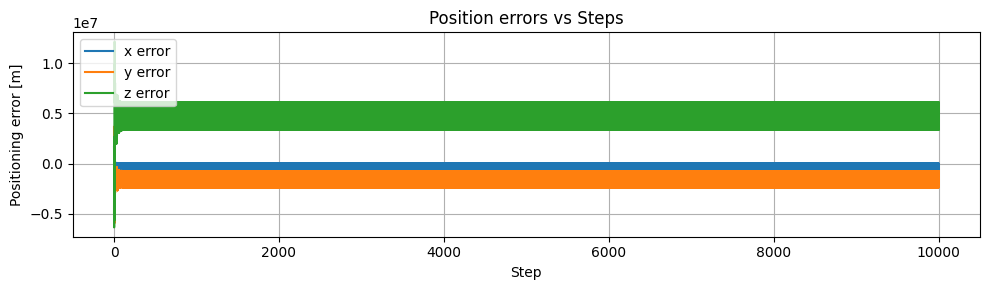

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
# (0.5 marks)
err_array = np.array(arr_err)
steps = np.arange(err_array.shape[0])
ax.plot(steps, err_array[:,0], label="x error")
ax.plot(steps, err_array[:,1], label="y error")
ax.plot(steps, err_array[:,2], label="z error")
ax.set_xlabel("Step")
ax.set_ylabel("Positioning error [m]")
ax.set_title("Position errors vs Steps")
ax.legend()
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# (0.5 marks)
# The positioning errors remain extremely high and do not decrease over time.
# The block of color indicates high-frequency oscillation
# where the estimated position jumps drastically in every iteration.
# The system fails to approach the true coordinates.
# This confirms that with a learning rate of 0.08, the Gradient Descent algorithm is divergent.
# If a smaller learning rate were used, these errors would decrease to near zero.

### **Hyperparameters Tuning**

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.008, 0.0008 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [51]:
#set learning rate to 0.008
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# (1 marks)
optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=0.008)
# print the metrics
print("Optimized parameters with lr = 0.008 [x, y, z, cdT]:")
print(optimized_params_2)
pos_error_vec_2 = optimized_params_2[:3] - GroundTruth
pos_error_norm_2 = np.linalg.norm(pos_error_vec_2)
print("Final 3D position error [m]:", pos_error_norm_2)
print("Number of steps taken (or max_iters):", steps_count)
final_cost_2 = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
final_grad_2 = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
print("Final cost value:", final_cost_2)
print("Final gradient:", final_grad_2)

Optimized parameters with lr = 0.008 [x, y, z, cdT]:
[-1.63349246e+06 -3.65162953e+06  4.95248541e+06 -6.69572571e+00]
Final 3D position error [m]: 5.415386195893553
Number of steps taken (or max_iters): 3592
Final cost value: 7.5715596550064905
Final gradient: [ 0.00048555  0.00270547 -0.00831509  0.00471401]


In [52]:
#set learning rate to 0.008
#re-initialize arrays and counters
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

# (1 marks)
optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=0.0008)


# print the metrics
print("Optimized parameters with lr = 0.0008 [x, y, z, cdT]:")
print(optimized_params_3)
pos_error_vec_3 = optimized_params_3[:3] - GroundTruth
pos_error_norm_3 = np.linalg.norm(pos_error_vec_3)
print("Final 3D position error [m]:", pos_error_norm_3)
print("Number of steps taken (or max_iters):", steps_count)
final_cost_3 = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
final_grad_3 = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
print("Final cost value:", final_cost_3)
print("Final gradient:", final_grad_3)

Optimized parameters with lr = 0.0008 [x, y, z, cdT]:
[-1632077.9709607  -3643754.17075749  4928283.81028123    13723.3327141 ]
Final 3D position error [m]: 25485.493165483702
Number of steps taken (or max_iters): 10000
Final cost value: 292097452.5989126
Final gradient: [   985.75489039   5484.1018742  -16851.2203243    9566.58733053]


### Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)


In [53]:
# When I increased the learning rate (e.g. from 0.0008 to 0.008), the algorithm converged much faster.
# The cost dropped steeply in the first steps, the gradients went to near zero quickly, and the position error reached a few metres in relatively few iterations.
# With the smaller learning rate, the cost and errors still decreased but much more slowly, so many more steps were needed and, within the same maximum iteration limit, the solution was less “finished” even though it remained very stable and monotonic.

# In this lab, LSE solves the problem by forming and inverting the normal equations.
# So each iteration makes a relatively “optimal” update and the solution converges in only a few steps to a good estimate.
# Gradient Descent, on the other hand, does not invert any matrices; it just follows the negative gradient of the cost with a chosen learning rate, so it is more general and avoids heavy linear algebra but needs many more small steps and careful tuning of the learning rate.
# In our results, both methods reached similar final positions, but LSE converged much faster and more directly, while Gradient Descent was slower and more sensitive to the chosen hyperparameters.

---
---

# **PART 2: Student Depression Prediction using Logistic Regression (30 Marks)**

The following depression dataset aims at analyzing, understanding, and predicting depression levels among students. It is collected from Shodolamu Opeyemi, and it can be downloaded from https://www.kaggle.com/datasets/hopesb/student-depression-dataset

**Dataset Description:**
- Features include academic pressure, age, CGPA, financial stress, work/study hours, and other psychological factors
- Target variable: Depression status (0 = Not Depressed, 1 = Depressed)

Follow the steps provided to perform binary classification using logistic regression and complete the analysis for each part.



### Step 0: Import Libraries

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Step 1: Data Input (2 marks)

Load the Student Depression Dataset from CSV file into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`

In [56]:
# Load the Student Depression Dataset
data = pd.read_csv('Student Depression Dataset.csv')

# Basic data preprocessing
data.drop(['id'], axis=1, inplace=True)  # Remove irrelevant ID column
data.dropna(inplace=True)  # Remove rows with missing values
data.drop_duplicates(inplace=True)  # Remove duplicate rows

# Remove 'Other' category entries as they provide no useful information (1 marks)
# your code here
data = data[data['Dietary Habits'] != 'Other']

# Print the shape of the dataset after preprocessing and display the first 5 rows using head()
# your code here
print(data.shape)
data.head()

(27898, 17)


,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


In [57]:
from sklearn.preprocessing import LabelEncoder

# Label encode categorical variables
labelencoder = LabelEncoder()
categorical_columns = ['City', 'Gender', 'Sleep Duration', 'Dietary Habits',
                      'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness',
                      'Degree', 'Profession']

for col in categorical_columns:
    if col in data.columns:
        data[col] = labelencoder.fit_transform(data[col])

# Prepare feature matrix X and target vector y (1 marks)
y = data['Depression'] # Target vector
X = data.drop(['Depression'], axis=1) # Feature matrix

# Display sizes of X and y
# your code here
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (27898, 16)
Shape of y: (27898,)


### Step 2.1: Class Label Histogram (1 marks)

Plot the histogram for each class label to visualize class distribution. Display the exact value of the samples for each class above the respective bins.

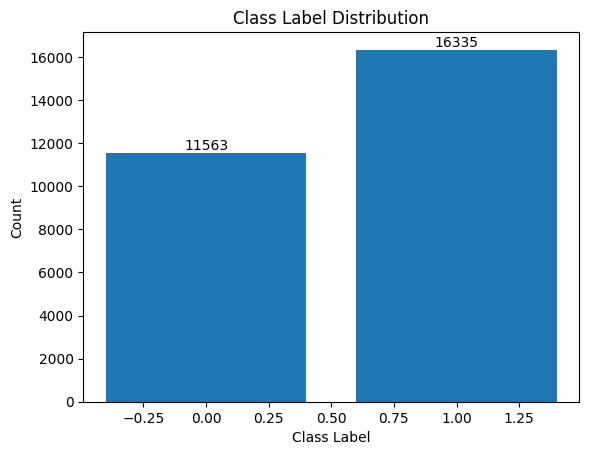

In [58]:
# Check the class distribution of y
counts = y.value_counts()

# Display exact values for each bin in the histogram
# hint: Use for loop
# your code here
plt.bar(counts.index, counts.values)
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Class Label Distribution')
for index, value in zip(counts.index, counts.values):
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()

### Step 2.2: Smaller Dataset Creation (1 marks)

We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42

In [59]:
from sklearn.model_selection import train_test_split

# Create a smaller dataset with 3% of the data (0.5 marks)
X_small, _, y_small, _ = train_test_split(X, y, train_size=0.03, random_state=42, stratify=y)

# Display sizes of X_small and y_small (0.5 marks)
print("Shape of X_small:", X_small.shape)
print("Shape of y_small:", y_small.shape)

Shape of X_small: (836, 16)
Shape of y_small: (836,)


### Step 3: Implement Machine Learning Model (3 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y` (1 mark)
    - Only first two columns of `X` and `y` (1 mark)  
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (3 x 3 = 9 marks)

Calculate the following for the **three different tests** implemented in Step 3:
1. data size (0.5 mark)
2. number of training samples (0.5 mark)
3. number of testing samples (0.5 mark)
4. training accuracy (0.5 mark)
5. testing accuracy (0.5 mark)
6. log loss (0.5 mark)

### Step 5.1: Visualize Results (2 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, use random_state = 0

In [60]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss

# Complete steps 3, 4, and 5.1 in this code block
# Note: 70% training set, 30% testing set
# Create a function that calculates all required information

model = LogisticRegression(max_iter=2000)
results = pd.DataFrame(columns=["Data size", "Training samples", "Testing samples",
                               "Training accuracy", "Testing accuracy", "Log loss"])

def evaluate_model(data_tuple):
    name, features, target = data_tuple
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

    model.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    loss = log_loss(y_test, model.predict_proba(X_test))

    global results
    results.loc[name] = [
        len(features),
        len(X_train),
        len(X_test),
        train_acc,
        test_acc,
        loss
    ]

    return X_train, X_test, y_train, y_test

# Test 1: Full dataset (X and y)
evaluate_model(("Full Dataset", X, y))

# Test 2: Only first two columns of X and y
evaluate_model(("First Two Columns", X.iloc[:, :2], y))

# Test 3: Small dataset (X_small and y_small)
evaluate_model(("Small Dataset", X_small, y_small))

print(results)

                   Data size  Training samples  Testing samples  \
Full Dataset         27898.0           19528.0           8370.0   
First Two Columns    27898.0           19528.0           8370.0   
Small Dataset          836.0             585.0            251.0   

                   Training accuracy  Testing accuracy  Log loss  
Full Dataset                0.846887          0.846117  0.348357  
First Two Columns           0.631708          0.634170  0.652715  
Small Dataset               0.851282          0.876494  0.309071  


### Step 5.2: Visualize Classification Errors (3 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis.

In [61]:
# Retrieve target vector and predicted values for testing set using full dataset
# (1 marks)
# Note: 70% training set, 30% testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


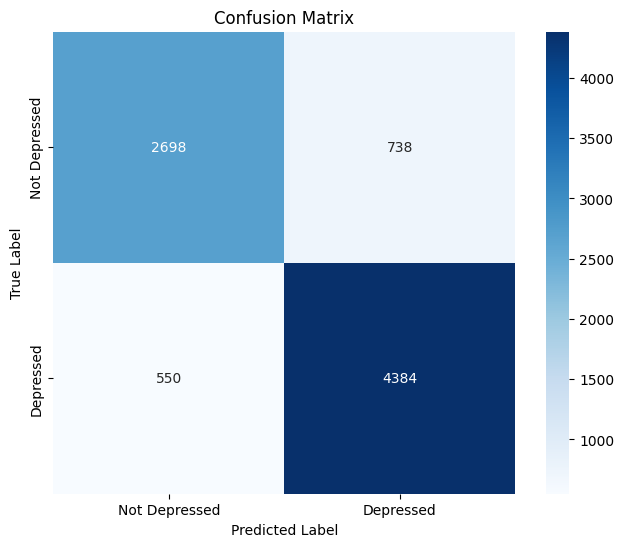

In [62]:
from sklearn.metrics import confusion_matrix
# Calculate confusion matrix: confusion_matrix()
# (1 marks)
conf_mat = confusion_matrix(y_test, y_pred)


# Print confusion matrix using a heatmap: sns.heatmap()
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat,
           xticklabels=['Not Depressed', 'Depressed'],
           yticklabels=['Not Depressed', 'Depressed'],
           square=True,
           annot=True,
           cbar=True,
           fmt='d',
           cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [63]:
from sklearn.metrics import classification_report
# Print classification report: classification_report()
# (1 marks)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.83      0.79      0.81      3436
           1       0.86      0.89      0.87      4934

    accuracy                           0.85      8370
   macro avg       0.84      0.84      0.84      8370
weighted avg       0.85      0.85      0.85      8370



### Additional Models Comparison (2 marks)

Let's compare the Logistic Regression with Naive Bayes and K-Nearest Neighbors models on the same dataset.

In [64]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Compare Logistic Regression, Naive Bayes, and KNN models
# Initialize models (0.5 marks)

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier()
}

# Train and evaluate each model using the full dataset (0.5 marks)
model_results = {}
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

for name, model_instance in models.items():
    # Train the model
    model_instance.fit(X_train, y_train)

    # Make predictions
    y_pred = model_instance.predict(X_test)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    model_results[name] = acc

    # Print results
    print(f"{name} Accuracy: {acc:.4f}")


Logistic Regression Accuracy: 0.8461
Naive Bayes Accuracy: 0.8364
KNN Accuracy: 0.7462


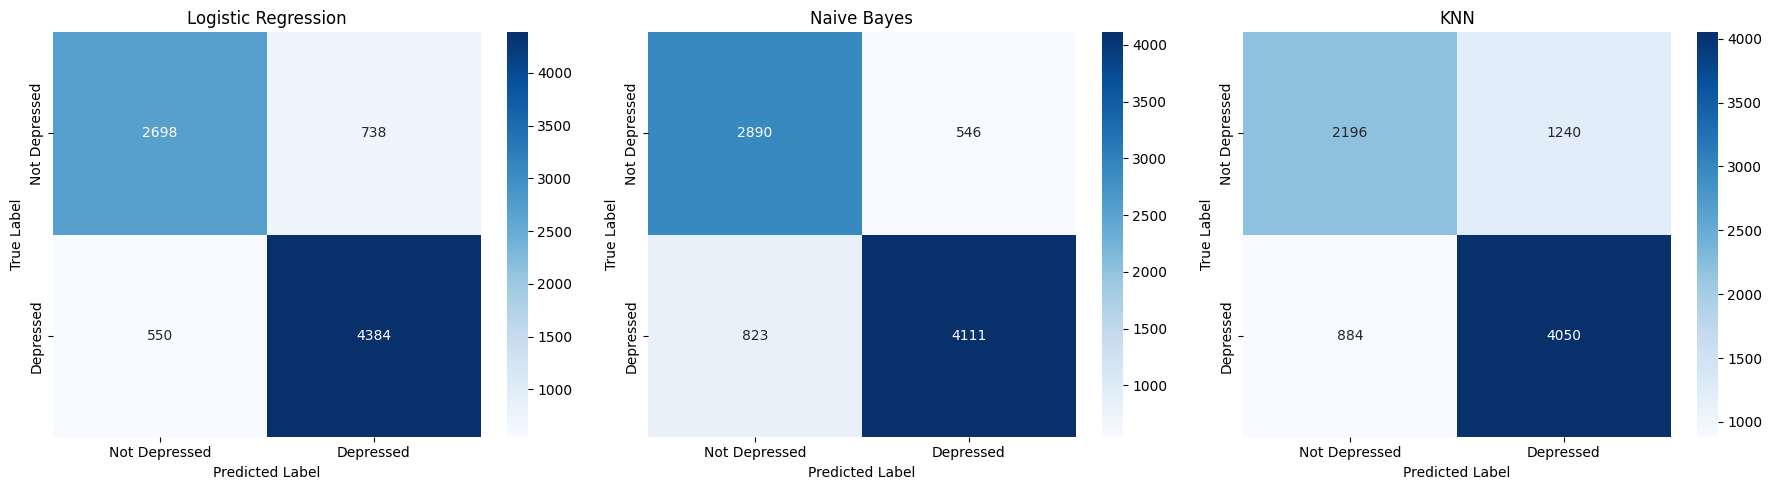

In [65]:
# Visualize confusion matrices for all models (You can use heatmap again)
# (1 marks)

plt.figure(figsize=(18, 5))
for i, (name, model_instance) in enumerate(models.items()):
    plt.subplot(1, 3, i + 1)
    y_pred = model_instance.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred)

    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Depressed', 'Depressed'],
                yticklabels=['Not Depressed', 'Depressed'])
    plt.title(name)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

### Questions and Analysis (7 marks)

1. Is the dataset balanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (1 marks)  
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (1 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (1 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (1 marks)
7. Compare the performance of Logistic Regression, Naive Bayes, and K-Nearest Neighbors models. Which performs best and why? Explain based on each algorithm's characteristics and assumptions. (1 marks)

### Answer here (double click)
1. The dataset is clearly imbalanced, with more “Depressed” samples than “Not Depressed.” Because of this, the model leans toward the majority class. It catches about 89% of depressed cases but only around 79% of non-depressed ones, showing a bias toward the larger class.

2. Using only the first two columns leads to underfitting—both train and test accuracy stay at 0.63, so the model isn’t learning enough.
With the full dataset, train and test scores (0.85) are close, so the model generalizes well.
For the small dataset, the accuracy looks high (0.87), but this tiny subset is unstable and could easily cause overfitting.

3. Adding more features increases accuracy a lot (from 63% to 85%), meaning the full set has useful information the model needs.
For sample size, the full dataset gives very consistent train/test results, while the small dataset varies a lot. A different split could produce much worse performance.

4. A false positive labels a healthy student as depressed, which could cause unnecessary concern or intervention.
A false negative is more serious because a depressed student may not get help. Since this can lead to severe consequences, reducing false negatives is more important.

5. I would maximize recall to reduce false negatives, mainly by lowering the classification threshold or increasing class weights.

6. The full dataset has a low log loss (0.35), showing the model is making confident, correct predictions.
The two-feature version has a high loss (0.65), basically meaning the model is close to guessing.
The small dataset shows a surprisingly low loss (0.31), but this number isn’t reliable because the tiny sample can be accidentally easy to separate.

7. Logistic Regression (0.85) performs best since it works well with tabular data containing both categorical and numeric features.
Naive Bayes (0.84) is slightly worse because several features are correlated, which breaks its independence assumption.
KNN (0.75) performs the worst due to high dimensionality from one-hot encoding and its sensitivity to unscaled data.

---
---

# **PART 3: MNIST Handwritten Digit Classification using MLP & CNN (30 Marks)**

This part compares two neural network architectures for handwritten digit classification:
- **Multi-Layer Perceptron (MLP)**: A traditional fully-connected neural network
- **Convolutional Neural Network (CNN)**: A specialized architecture for image processing


The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. This dataset we're using uses the work of Joseph Redmon to provide the MNIST dataset in a CSV format. And it can be downloaded from https://www.kaggle.com/datasets/hojjatk/mnist-dataset

The dataset consists of two files:
- mnist_train.csv
- mnist_test.csv

The mnist_train.csv file contains the 60,000 training examples and labels. The mnist_test.csv contains 10,000 test examples and labels. Each row consists of 785 values: the first value is the label (a number from 0 to 9) and the remaining 784 values are the pixel values (a number from 0 to 255).

Acknowledgements:
- Yann LeCun, Courant Institute, NYU
- Corinna Cortes, Google Labs, New York
- Christopher J.C. Burges, Microsoft Research, Redmond

![MNIST dataset](https://upload.wikimedia.org/wikipedia/commons/b/b1/MNIST_dataset_example.png)

We'll train both models on the MNIST dataset and compare their performance.

### Step 1: Library Imports

Import the necessary libraries for data processing, model building, and evaluation.

In [ ]:
# Library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/ENGG_680_Fall2025_Assignment2

/content/drive/MyDrive/ENGG_680_Fall2025_Assignment2


### Step 2: Dataset Loading (2 marks)

Load the MNIST dataset from CSV files. The MNIST dataset contains 70,000 images of handwritten digits (0-9).

Then visualize some sample images.

In [ ]:
# Load MNIST dataset from CSV files
train_csv_path = '/content/drive/MyDrive/ENGG_680_Fall2025_Assignment2/mnist_train.csv'
test_csv_path = '/content/drive/MyDrive/ENGG_680_Fall2025_Assignment2/mnist_test.csv'

# Load training data
# The first line is the label, the rest are pixel values
# (0.5 marks)
train_data = pd.read_csv(train_csv_path)
y_train = train_data.iloc[:, 0].values.astype(int)
X_train = train_data.iloc[:, 1:].values.astype(np.float32)

# CSV stores each image as a single row of 784 pixels
# Reshape from flat array (784,) to 2D image format (28, 28)
# (0.5 marks)
X_train = X_train.reshape(-1, 28, 28)

# Load test data (0.5 marks)
test_data = pd.read_csv(test_csv_path)
y_test = test_data.iloc[:, 0].values.astype(int)
X_test = test_data.iloc[:, 1:].values.astype(np.float32)

# Reshape test data to match training data format
X_test = X_test.reshape(-1, 28, 28)

# Display the shapes of training and test sets
print(f"Training set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Test set: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")

Training set: X_train shape = (60000, 28, 28), y_train shape = (60000,)
Test set: X_test shape = (10000, 28, 28), y_test shape = (10000,)


Let's visualize some sample images to understand what our models will be learning from.

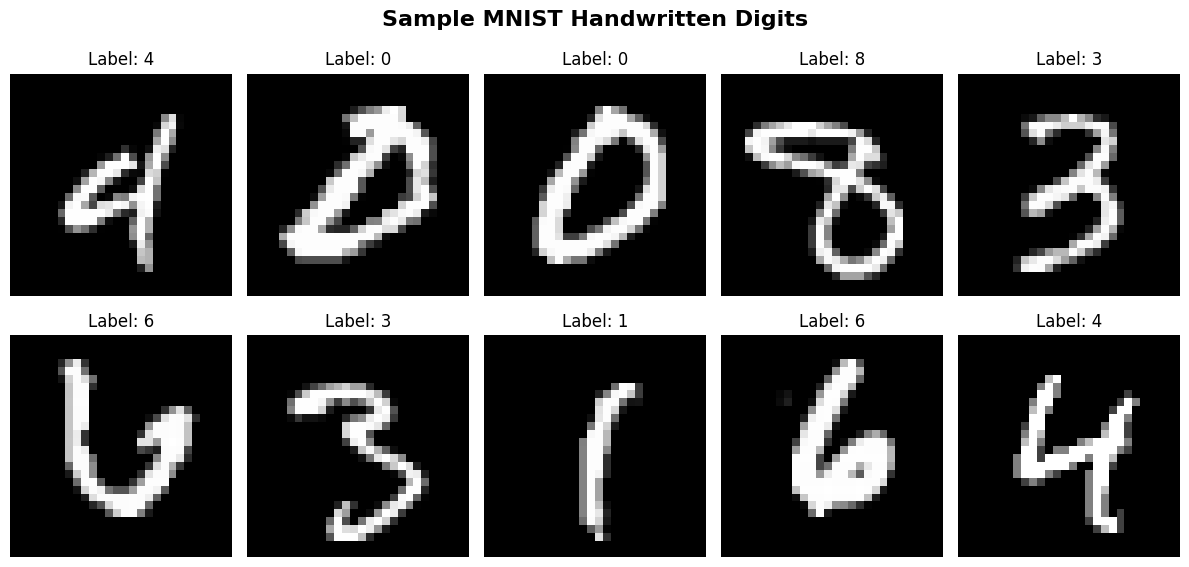

In [ ]:
# Visualize sample images from the dataset as a grid of 10 images (2 rows x 5 columns)
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle('Sample MNIST Handwritten Digits', fontsize=16, fontweight='bold')

# Display 10 random samples
# Use a loop
for i in range(10):
    row = i // 5
    col = i % 5

    # Get a random sample
    idx = np.random.randint(0, len(X_train))
    image = X_train[idx]
    label = y_train[idx]

    # Display the image
    axes[row, col].imshow(image, cmap='gray')
    axes[row, col].set_title(f'Label: {label}', fontsize=12)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

### Step 3: Data Preprocessing (1 mark)

Normalize pixel values to [0,1] range and convert labels to one-hot encoding for multi-class classification.

Why normalize? Neural networks work better with smaller input values (0-1 vs 0-255)
- Faster convergence during training
- Prevents gradient explosion/vanishing
- Makes learning more stable

Why one-hot? Transform labels from integers (0,1,2...9) to binary vectors

- Example: label "3" becomes [0,0,0,1,0,0,0,0,0,0]

- This allows softmax output layer to predict probabilities for each class

In [ ]:
# Normalize pixel values from [0, 255] to [0, 1]
# hint: divide by 255.0 (0.5 marks)
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

# Convert labels to one-hot encoding for multi-class classification
# (0.5 marks)
num_classes = 10
y_train_categorical = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = tf.keras.utils.to_categorical(y_test, num_classes)

### Step 4: MLP Model Creation and Training (7 marks)

Create a Multi-Layer Perceptron model with fully connected layers. This model treats each pixel as an independent feature.

This created model can be used for fit, predict and evaluate the dataset through calling mlp_model.fit(), mlp_model.predict() and mlp_model.evaluate(), you can consider it as a inbuild model right now.

Hint: We will use tf.keras.layers function, and add flatten layer, hidden layer, dropout layer, hidden layer, dropout layer and output layer.

In [ ]:
# Create MLP model, add each of layers with the correct parameters

def create_mlp_model():
    model = tf.keras.Sequential([
        # Flatten layer: Convert 2D image (28x28) to 1D array (784)
        # MLP needs flat input, treats each pixel as independent feature
        # (1 marks)
        tf.keras.layers.Flatten(input_shape=(28, 28)),

        # First hidden layer: 128 neurons with ReLU activation
        # ReLU = max(0, x), helps with vanishing gradient problem
        # (1 marks)
        tf.keras.layers.Dense(128, activation='relu'),

        # Dropout layer: Randomly sets 20% of inputs to 0 during training
        # Prevents overfitting by forcing network to learn redundant representations
        # (1 marks)
        tf.keras.layers.Dropout(0.2),

        # Second hidden layer: 64 neurons with ReLU activation
        # Smaller layer creates hierarchical feature representation
        # (1 marks)
        tf.keras.layers.Dense(64, activation='relu'),

        # Another dropout layer for regularization
        # (1 marks)
        tf.keras.layers.Dropout(0.2),

        # Output layer: 10 neurons (one for each digit 0-9)
        # Softmax converts outputs to probabilities that sum to 1
        # (1 marks)
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Compile model with optimizer, loss function, and metrics
    # Adam: adaptive learning rate optimizer
    # Categorical crossentropy: loss for multi-class classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

**Use .fit() to train MLP model**

In [ ]:
# EPOCHS: Number of complete passes through entire training dataset
# (0.5 marks)
EPOCHS = 5

# BATCH_SIZE: Number of samples processed before updating weights
# Larger batch = more stable gradients but more memory
# Use 128 as batch size
# (0.5 marks)
BATCH_SIZE = 128

mlp_model = create_mlp_model()

# Train MLP model using mlp_model we compiled.
# Use 10% of training data for validation, validation_split
# Silent training (no progress output), verbose=0
mlp_history = mlp_model.fit(
    X_train_normalized, y_train_categorical,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=0
)

print("MLP training completed")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MLP training completed


### Step 5: CNN Model Creation and Training (7 marks)

Create a Convolutional Neural Network with convolutional and pooling layers. This model preserves spatial relationships between pixels.

#### Fundamental Difference between MLP and CCN:

**Key Architectural Differences:**
- **MLP**: Input → Flatten → Dense layers → Output (treats pixels independently)
- **CNN**: Input → Reshape → Conv+Pool layers → Flatten → Dense layers → Output (learns spatial patterns first)

**The CNN Advantage:**
1. **Convolutional Layers**: Extract spatial features (edges, curves, shapes) that MLP cannot detect
2. **Pooling Layers**: Provide translation invariance and reduce computational load
3. **Feature Hierarchy**: Early layers detect simple patterns, deeper layers combine them into complex features
4. **Parameter Sharing**: Same filter applied across entire image, making CNN more efficient

**Why CNNs End with Dense Layers:**
- Convolutional layers act as **feature extractors** (learn "what" is in the image)
- Dense layers act as **classifiers** (decide "which digit" based on extracted features)
- This is a common pattern: **Feature Extraction (CNN) + Classification (MLP)**

**The Real Difference:**
- **MLP Dense layers**: Work with raw pixel values (784 individual numbers)
- **CNN Dense layers**: Work with high-level spatial features learned by convolutional layers

Hint: We will use tf.keras.layers function again, reshape it firstly, then add Conv2D, MaxPooling2D, Conv2D, MaxPooling2D, Conv2D, and do same last two steps like MLP.

In [ ]:
# Similar process with creating MLP model
# Create CNN model - Different from MLP in how it processes spatial data
def create_cnn_model():
    model = tf.keras.Sequential([
        # Reshape: Add channel dimension (28, 28) -> (28, 28, 1)
        # CNNs expect 3D input (height, width, channels)
        tf.keras.layers.Reshape((28, 28, 1), input_shape=(28, 28)),

        # Conv2D: Applies 32 filters of size 3x3 to detect features
        # Each filter learns to detect different patterns (edges, curves)
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),

        # Reduces image size by taking maximum value in 2x2 windows
        # Helps reduce computation and provides translation invariance
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Conv2D: Second convolutional layer, 64 filters
        # Learns more complex features from the first layer's output
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

        # MaxPooling2D: Another pooling layer to reduce spatial dimensions
        tf.keras.layers.MaxPooling2D((2, 2)),

        # Conv2D: Third convolutional layer, 64 filters
        # Captures even more abstract features
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),

        # Flatten: Convert feature maps to 1D for dense layers
        tf.keras.layers.Flatten(),

        # Dense layers: Same as MLP, but now working with learned features
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    # Same compile step with MLP (1 marks)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

**Use .fit() to train CNN model**

In [ ]:
# Train CNN model using cnn_model we compiled, same hyperparameters as MLP
# (1 marks)

cnn_model = create_cnn_model()

cnn_history = cnn_model.fit(
    X_train_normalized, y_train_categorical,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.1,
    verbose=0
)

print("CNN training completed")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


CNN training completed


### Step 6: Model Evaluation and Comparison (4 marks)

Evaluate both models on the test set and compare their performance with visualizations.

Using .predict(), .evaluate() functions as we used in part2

In [ ]:
# Evaluate both models on test set
# Get test loss and accuracy, make predictions, convert to class labels

# your code here for mlp (1.5 marks)
mlp_loss, mlp_accuracy = mlp_model.evaluate(X_test_normalized, y_test_categorical, verbose=0)

# Note: The model outputs class probabilities (10 values per sample)
# These integer labels (0-9) are required for comparison
mlp_predictions = mlp_model.predict(X_test_normalized, verbose=0)
mlp_predicted_classes = np.argmax(mlp_predictions, axis=1)

# your code here for cnn (1.5 marks)
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test_normalized, y_test_categorical, verbose=0)

# Similarly, convert CNN predicted probabilities to class labels
cnn_predictions = cnn_model.predict(X_test_normalized, verbose=0)
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)

# Display Results
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")
print(f"CNN Test Accuracy: {cnn_accuracy:.4f}")
print(f"Accuracy Improvement: {((cnn_accuracy - mlp_accuracy) / mlp_accuracy * 100):.2f}%")

MLP Test Accuracy: 0.9712
CNN Test Accuracy: 0.9902
Accuracy Improvement: 1.96%


Performance comparison visualization

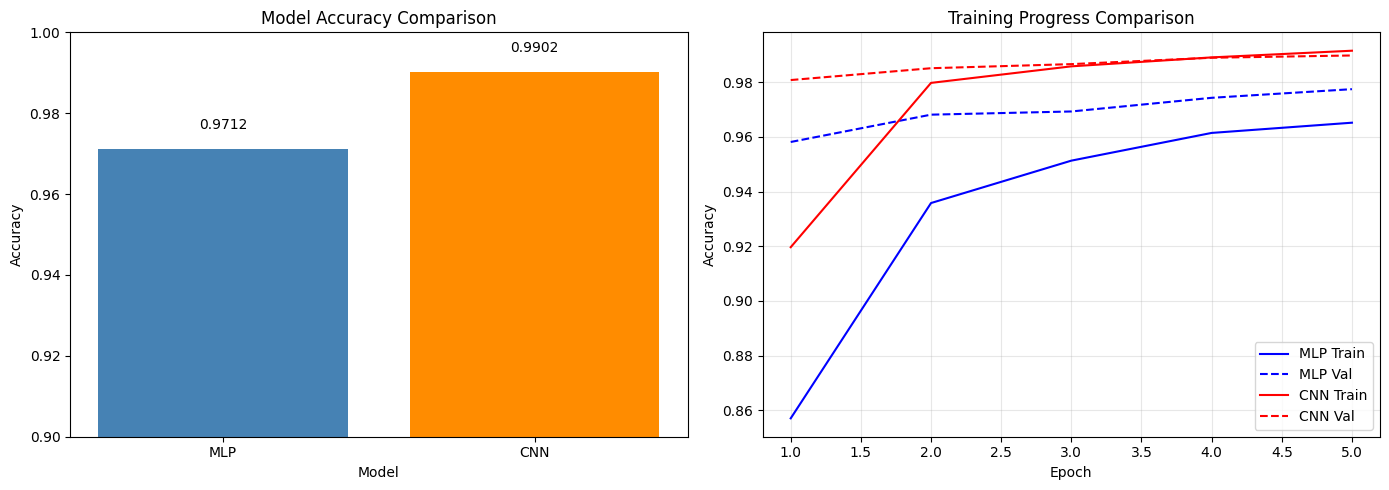

In [ ]:
# Create side-by-side bar chart for model accuracy comparison and training curves
# (1 marks)
# put them in a single figure horizontally
# Add titles, labels, legends for clarity
# hint: use .history() function to get training history

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy Comparison Bar Chart
models = ['MLP', 'CNN']
accuracies = [mlp_accuracy, cnn_accuracy]
colors = ['steelblue', 'darkorange']
axes[0].bar(models, accuracies, color=colors)
axes[0].set_ylim(0.9, 1.0)
axes[0].set_xlabel('Model')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Comparison')
for i, acc in enumerate(accuracies):
    axes[0].text(i, acc + 0.005, f'{acc:.4f}', ha='center', fontsize=10)

# Plot 2: Training Curves
epochs_range = range(1, EPOCHS + 1)
axes[1].plot(epochs_range, mlp_history.history['accuracy'], 'b-', label='MLP Train')
axes[1].plot(epochs_range, mlp_history.history['val_accuracy'], 'b--', label='MLP Val')
axes[1].plot(epochs_range, cnn_history.history['accuracy'], 'r-', label='CNN Train')
axes[1].plot(epochs_range, cnn_history.history['val_accuracy'], 'r--', label='CNN Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Training Progress Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Step 7: Prediction Analysis Visualization (4 marks)

Let's examine some specific predictions to see how each model performs on individual samples.

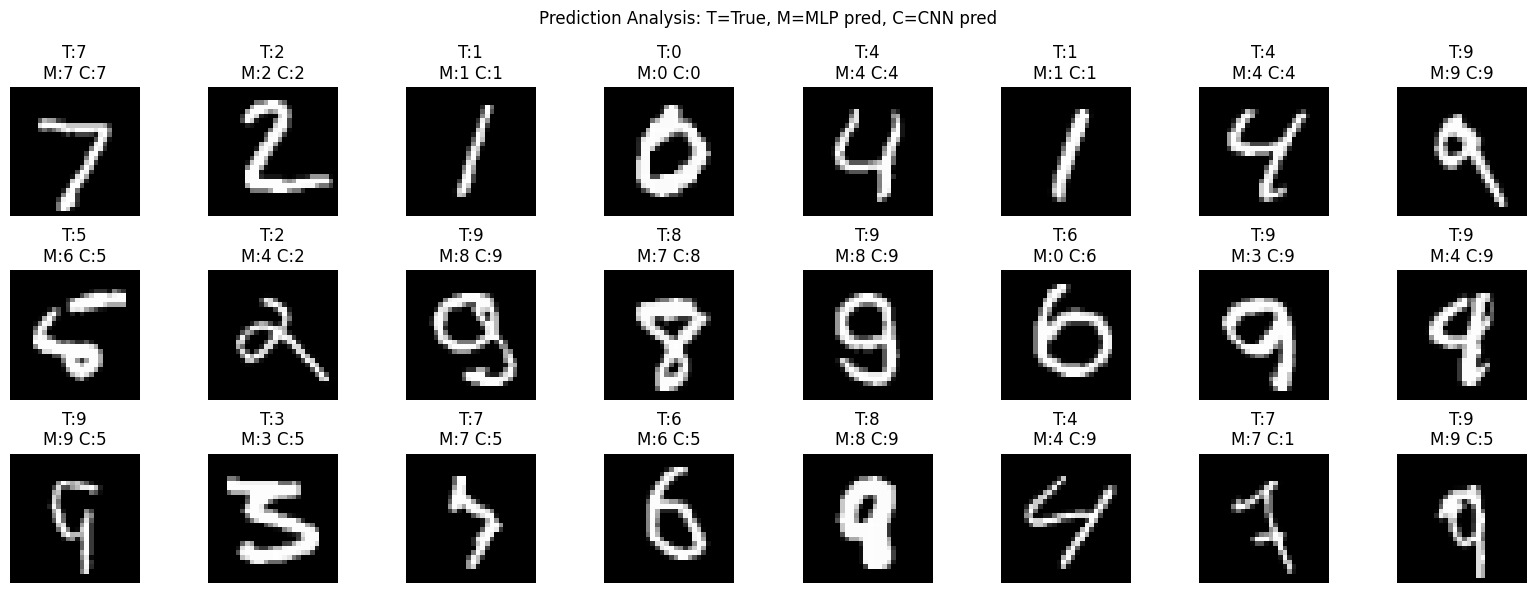

In [ ]:
# Visualize correct and incorrect predictions, showing where models differ
# First row: Both models correct
# Second row: CNN correct, MLP wrong
# Third row: MLP correct, CNN wrong

# Create subplots
# your code here (1 marks)
fig, axes = plt.subplots(3, 8, figsize=(16, 6))

# Find correct predictions for each case
# Sample for both_correct
both_correct = (mlp_predicted_classes == y_test) & (cnn_predicted_classes == y_test)
both_correct_indices = np.where(both_correct)[0][:8]

# your code here (1 marks)
# CNN correct, MLP wrong
cnn_correct_mlp_wrong = (cnn_predicted_classes == y_test) & (mlp_predicted_classes != y_test)
cnn_correct_mlp_wrong_indices = np.where(cnn_correct_mlp_wrong)[0][:8]

# MLP correct, CNN wrong
mlp_correct_cnn_wrong = (mlp_predicted_classes == y_test) & (cnn_predicted_classes != y_test)
mlp_correct_cnn_wrong_indices = np.where(mlp_correct_cnn_wrong)[0][:8]

# Plot examples, you can learn how to plot them from the previous steps
# Add a title for each graph showing the true label and predicted labels
# hint: use for loop to iterate through the indices
# your code here (2 marks)

# Row 1: Both correct
for i, idx in enumerate(both_correct_indices):
    axes[0, i].imshow(X_test[idx], cmap='gray')
    axes[0, i].set_title(f'T:{y_test[idx]}\nM:{mlp_predicted_classes[idx]} C:{cnn_predicted_classes[idx]}')
    axes[0, i].axis('off')
axes[0, 0].set_ylabel('Both Correct', fontsize=10)

# Row 2: CNN correct, MLP wrong
for i, idx in enumerate(cnn_correct_mlp_wrong_indices):
    axes[1, i].imshow(X_test[idx], cmap='gray')
    axes[1, i].set_title(f'T:{y_test[idx]}\nM:{mlp_predicted_classes[idx]} C:{cnn_predicted_classes[idx]}')
    axes[1, i].axis('off')
axes[1, 0].set_ylabel('CNN>MLP', fontsize=10)

# Row 3: MLP correct, CNN wrong
for i, idx in enumerate(mlp_correct_cnn_wrong_indices):
    axes[2, i].imshow(X_test[idx], cmap='gray')
    axes[2, i].set_title(f'T:{y_test[idx]}\nM:{mlp_predicted_classes[idx]} C:{cnn_predicted_classes[idx]}')
    axes[2, i].axis('off')
axes[2, 0].set_ylabel('MLP>CNN', fontsize=10)

plt.suptitle('Prediction Analysis: T=True, M=MLP pred, C=CNN pred', fontsize=12)
plt.tight_layout()
plt.show()

## Questions and Analysis (5 marks)

1. Which model performed better and why? (1 marks)
2. How do the training curves compare between the two models? (1 marks)
3. What does the accuracy improvement percentage tell us? (1 marks)
4. Why didn't we need many epochs for good results? (1 marks)
5. What would happen with more complex images? (1 marks)

**Answers**

1.Which model performed better and why?

The CNN performed better than the MLP because CNNs are specifically designed for image data. CNNs use convolutional layers that can detect spatial patterns like edges, curves, and shapes while preserving the spatial relationships between pixels. In contrast, MLPs flatten the image into a 1D array, losing all spatial information and treating each pixel as an independent feature.


2.How do the training curves compare between the two models?

The CNN typically shows faster convergence and reaches higher accuracy sooner than the MLP. Both models show the training accuracy increasing over epochs, but CNN's validation accuracy is generally higher and more stable. The MLP may show more oscillation in validation accuracy, indicating it struggles more to generalize from the training data.


3.What does the accuracy improvement percentage tell us?

The accuracy improvement percentage quantifies how much better the CNN performs compared to the MLP. A positive improvement (e.g., 1-2%) indicates that CNN's ability to learn spatial features provides measurable benefits for digit classification. Even small improvements are significant when dealing with large test sets, as they translate to many more correct predictions.


4.Why didn't we need many epochs for good results?

MNIST is a relatively simple dataset with clear, distinct digit patterns. The neural networks can learn to recognize these patterns quickly. Additionally, both models have appropriate architectures for this task, and the Adam optimizer with adaptive learning rates helps achieve fast convergence. More complex datasets would require more epochs.


5.What would happen with more complex images?

With more complex images (higher resolution, color, more classes, varied backgrounds), the gap between CNN and MLP would widen significantly. CNNs would maintain their advantage through hierarchical feature learning, while MLPs would struggle due to the exponentially increasing input dimensions and lack of spatial awareness. Deeper CNN architectures and more epochs would be needed.
